author: Ollie Jackson

description: various resampling methods and tests to assess if the difference in 4lac and sdss voidiness distributions
can be attributed to sources in voids

# Is the 3.97 sigma from 4LAC in void vs. SDSS real? No. 

In [299]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from shapely.geometry import Point, Polygon
from astropy.cosmology import WMAP9 as cosmo
from voidiness import voidy_analysis
from scipy import stats
from scipy.special import erfinv
from astropy.io import fits
import time
from scipy.optimize import curve_fit
cmap = plt.get_cmap("tab10")

params = {#'backend': 'ps',
      'axes.labelsize': 15,
      'xtick.labelsize': 15,
      'ytick.labelsize': 15,
      'legend.fontsize': 15}
plt.rcParams.update(params)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [88]:
fourlac = pd.read_excel('exported_dataFrames/4lacsutter_w_voidiness_dup_drop_above_z0_1.xlsx')
sutter_voids = pd.read_excel('processedsutter_voids.xlsx')

fourlac_dist = fourlac[fourlac.z >= 0.4]

sutter_footprint = pd.read_excel('exported_dataFrames/footprint_points_sutter.xlsx')

polygon = Polygon(zip(sutter_footprint['RAdeg'], sutter_footprint['DEdeg']))
minx, miny, maxx, maxy = polygon.bounds

In [300]:
def gaussian(x,a,b,c):
    return a*np.exp(-1*(x-c)**2/(2*b**2))

In [63]:
# Function to convert RA, DEC, redshift to 3D coordinates (x, y, z)

def get_3d_coordinates(ra, dec, redshift, distance):
    # Assuming the redshift corresponds to a comoving distance
    # For simplicity, assume a cosmology where distance in Mpc is proportional to redshift
    # Convert RA, DEC to radians
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    
    # Spherical to Cartesian conversion
    x = (distance * np.cos(dec_rad) * np.cos(ra_rad)).values #Mpc
    y = (distance * np.cos(dec_rad) * np.sin(ra_rad)).values #Mpc
    z = (distance * np.sin(dec_rad)).values #Mpc
  
    locs = []
    for i in range(len(x)):
        locs.append([x[i], y[i], z[i]])
    
    return np.asarray(locs)

In [93]:
def z_matching(z_SDSS_QSO_04, Voidiness_SDSS_QSO_04, norm_hist_z_SDSS, nb_to_keep, bin_edges):

    z_matched_SDSS = []
    Voidiness_matched_SDSS = []
    hist_z_matched_SDSS = [0] * norm_hist_z_SDSS
    #print(len(hist_z_matched_SDSS))
    z_SDSS_QSO_tmp = z_SDSS_QSO_04[:]
    Voidiness_SDSS_QSO_tmp = Voidiness_SDSS_QSO_04[:]
    #pick a random source with redshift (kind of acceptance/reject method)
    while sum(hist_z_matched_SDSS) < sum(nb_to_keep):
        index = np.random.randint(len(z_SDSS_QSO_tmp))
        for i in range(1,len(bin_edges)):
            if bin_edges[i-1] <= z_SDSS_QSO_tmp[index] < bin_edges[i] and hist_z_matched_SDSS[i-1] < nb_to_keep[i-1]:
                z_matched_SDSS.append(z_SDSS_QSO_tmp[index])
                Voidiness_matched_SDSS.append(Voidiness_SDSS_QSO_tmp[index])
                hist_z_matched_SDSS[i-1] += 1
                #remove indexes to not use them again
                del z_SDSS_QSO_tmp[index]
                del Voidiness_SDSS_QSO_tmp[index]
                break
                #print(hist_z_matched_SDSS)
    return(z_matched_SDSS, Voidiness_matched_SDSS)

In [118]:
p_vals = []
ks_vals = []
sigma_vals = []

In [232]:
#creating popualation with the same redshift distribution as 4lac sources in the distant redshift bin
#  but random locations within the void footprint, then determining how many of them are within voids, 
#  creating a redshift matched population of SDSS quasars that matches the redshift distribution of the 
#  mock 4lac sources in voids, and then runs a KS test between the two populations

def resample_test(n):
    p_vals = []
    ks_vals = []
    sigma_vals = []
    i = 0
    while i < n:
        fourlac_resampled = pd.DataFrame()
        fourlac_resampled['z'] = fourlac_dist.z

        RAdeg = []
        DEdeg = []
        filled = 0
        attempts = 0
        max_attempts = 100000  # safety in case it's small and hard to hit

        while filled < len(fourlac_dist) and attempts < max_attempts: #want same number of sources as 4lac (142)
            # Sample random points in the bounding box
            x_rand = np.random.uniform(minx, maxx)
            y_rand = np.random.uniform(miny, maxy)
            point = Point(x_rand, y_rand)
            if polygon.contains(point): #create random points but only accept point if its within the void footprint
                RAdeg.append(x_rand)
                DEdeg.append(y_rand)
                filled += 1
            attempts += 1
        
        #print(filled)
        
        fourlac_resampled['RAdeg'] = RAdeg
        fourlac_resampled['DEdeg'] = DEdeg
        cmvd = cosmo.comoving_distance(fourlac_resampled['z']) # Comoving distance to void center
        fourlac_resampled['cmvd_Mpc'] = cmvd.value # add it to data table


        #calculating voidiness of new dataframe
        fourlac_w_voidiness = voidy_analysis(sutter_voids, fourlac_resampled)

        source_coords = get_3d_coordinates(fourlac_w_voidiness['RAdeg'], fourlac_w_voidiness['DEdeg'], fourlac_w_voidiness['z'], fourlac_w_voidiness['cmvd_Mpc'])
        sphere_coords = get_3d_coordinates(sutter_voids['RAdeg'], sutter_voids['DEdeg'], sutter_voids['z'], sutter_voids['cmvd_Mpc'])

        # Checking if point sources are inside any sphere
        source_locs = []
        void_locs = []
        #void_rad = []
        for j in range(len(source_coords)):
            for i in range(len(sphere_coords)):
                distance = np.linalg.norm(source_coords[j] - sphere_coords[i])
        
                if distance <= sutter_voids.iloc[i]['Reff_Mpc']:
                    source_locs.append(j)
                    void_locs.append(i)
                    #void_rad.append(i)

        sources_in_voids = fourlac_w_voidiness.iloc[source_locs]
        voids_w_sources = sutter_voids.iloc[void_locs]

        sources_in_voids_dupdrop = sources_in_voids.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')
        sources_in_voids_dupdrop = sources_in_voids_dupdrop.reset_index(drop=True)

        #print(len(sources_in_voids_dupdrop))


        four_lac = sources_in_voids_dupdrop #pd.read_excel('exported_dataFrames/4lacsutter_invoids.xlsx')
        z_4LAC = sources_in_voids_dupdrop["z"]
        #select only redshifts <= 0.4
        z_4LAC_04 = []
        for i in range(len(z_4LAC)): #only running KS test for distant redshift bin
            if z_4LAC[i] >= 0.4:
                z_4LAC_04.append(z_4LAC[i])


        #print("read SDSS...")
        SDSS = pd.read_excel('exported_dataFrames/sdsssutter_w_voidiness_dup_drop_above_z0_1.xlsx')
        #class_SDSS = SDSS["AUTOCLASS_PQN"]
        z_SDSS = SDSS["z"]
        Voidiness_SDSS = SDSS["Voidiness"]

        z_SDSS_QSO_04 = []
        Voidiness_SDSS_QSO_04 = []
        for i in range(len(z_SDSS)):
            if 0.4 <= z_SDSS[i] < 0.7:
                z_SDSS_QSO_04.append(z_SDSS[i])
                Voidiness_SDSS_QSO_04.append(Voidiness_SDSS[i])



        bin_edges = np.linspace(0.4,0.7,13)

        #creating redshift matched SDSS population - code from redshift-matched_check.py
        
        plt.figure("Redshift distribution")
        hist_z_4LAC = np.histogram(z_4LAC_04,bins=bin_edges)
        norm_hist_z_4LAC = hist_z_4LAC[0] / float(len(z_4LAC_04)) #histogram normalization
        plt.stairs(norm_hist_z_4LAC,edges=bin_edges,lw=2,label="Fermi 4LAC")

        hist_z_SDSS = np.histogram(z_SDSS_QSO_04,bins=bin_edges)
        norm_hist_z_SDSS = hist_z_SDSS[0] / float(len(z_SDSS_QSO_04)) #histogram normalization
        plt.stairs(norm_hist_z_SDSS,edges=bin_edges,lw=2,label="SDSS QSOs")

        anchor_4LAC = hist_z_4LAC[0][0]
        bins_frac_4LAC = hist_z_4LAC[0]/anchor_4LAC

        anchor_SDSS = hist_z_SDSS[0][0]
        bins_frac_SDSS = hist_z_SDSS[0]/anchor_SDSS

        #how many sources need to keep in SDSS for each bin?
        nb_to_keep = np.round(anchor_SDSS*(bins_frac_4LAC)).astype(int)

        print("building z-matched sample...")

        z_matched_SDSS, Voidiness_matched_SDSS = z_matching(z_SDSS_QSO_04, Voidiness_SDSS_QSO_04, norm_hist_z_SDSS, nb_to_keep, bin_edges)

        hist_z_matched_SDSS = np.histogram(z_matched_SDSS,bins=bin_edges)
        norm_hist_z_matched_SDSS = hist_z_matched_SDSS[0] / float(len(z_matched_SDSS)) #histogram normalization
        plt.stairs(norm_hist_z_matched_SDSS,edges=bin_edges,lw=2,ls="--",color=cmap(3),label="SDSS QSOs z-matched")
        plt.xlabel(r'Redshift')
        plt.ylabel(r'Normalized $\#$ of sources')
        plt.legend()
        plt.show()


        bin_edges_voids = np.linspace(0.1,0.9,19)
        nbins = 499
        all_hist = [0] *nbins
        COL = [0] *nbins*2
        #plt.figure("Voidiness")
        #plt.title(r"$0.1 \leq z < 0.4$")
        for i in range(nbins):
            z_matched_SDSS, Voidiness_matched_SDSS = z_matching(z_SDSS_QSO_04, Voidiness_SDSS_QSO_04, norm_hist_z_SDSS, nb_to_keep, bin_edges)
            COL[i*2] = fits.Column(name='Redshift'+str(i+1), unit= 'z',  format='D', array=z_matched_SDSS)
            COL[i*2+1] = fits.Column(name='Voidiness'+str(i+1),  format='D', array=Voidiness_matched_SDSS)
            aa = plt.hist(Voidiness_matched_SDSS,bins=bin_edges_voids,fill=False, lw=2, alpha = 0.1, color="0.6",histtype='step',zorder=0)
            all_hist[i] = aa[0]
        median_voids = np.median(all_hist,axis=0)

        hdu = fits.BinTableHDU.from_columns(COL)


        # running KS test between populations
        
        four_lac = sources_in_voids_dupdrop
        z_4LAC = four_lac["z"]
        #select only redshifts < 0.4
        z_4LAC_04 = []
        Voidiness = []
        for i in range(len(z_4LAC)):
            if 0.4 <= z_4LAC[i] < 0.7:
                z_4LAC_04.append(z_4LAC[i])
                Voidiness.append(four_lac["Voidiness"][i])
        Voidiness = np.array(Voidiness)

        tbdata = hdu.data  # assume the first extension is a table
        tbcolumns = hdu.columns

        nbins = 20
        Pval_KS = [0]*499
        stats_KS = [0]*499
        Voidiness_SDSS = [0]*499
        Z_matched_Voidiness_array = [0]*499
        #plt.figure("Voidiness z-matched samples")
        #plt.xlabel(r'Voidiness')
        #plt.ylabel(r'$\#$ of z-matched SDSS samples')
        for i in range(499):
            #plt.hist(tbdata["Voidiness"+str(i+1)],bins=nbins,fill=False,histtype='step',color='0.5',lw=2,alpha=0.1,label="Randomized coordinates")
            Voidiness_SDSS[i] = np.mean(tbdata["Voidiness"+str(i+1)])
            #KS test
            KS,pval = stats.ks_2samp(Voidiness, tbdata["Voidiness"+str(i+1)])
            #res = stats.anderson_ksamp([Voidiness, tbdata["Voidiness"+str(i+1)]], method=stats.PermutationMethod())
            Pval_KS[i] = pval
            stats_KS[i] = KS
            Z_matched_Voidiness_array[i] = tbdata["Voidiness"+str(i+1)]

        Z_matched_Voidiness_array = np.array(Z_matched_Voidiness_array)

        P_med = np.median(Pval_KS)
        aa = np.median(stats_KS)
        sigma = np.sqrt(2) * erfinv(1-2*P_med)

        p_vals.append(P_med)
        ks_vals.append(aa)
        sigma_vals.append(sigma)

        i += 1

    return p_vals, ks_vals, sigma_vals


30
building z-matched sample...


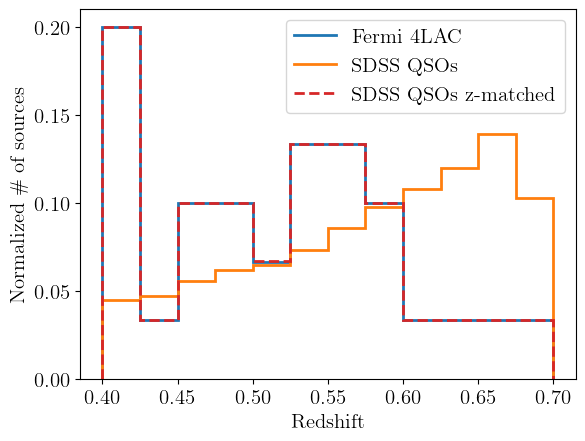

Operation took 245.5345 seconds


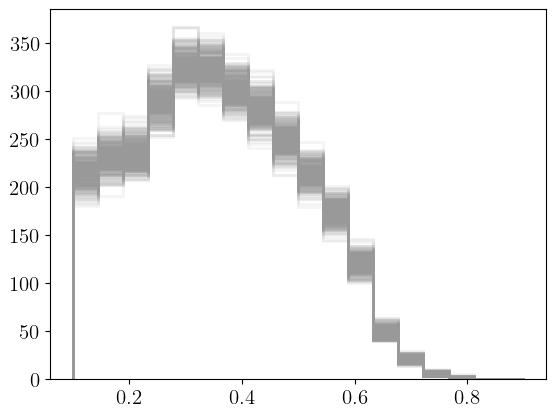

In [492]:
#the above function takes ~4 minutes per run, so I ran it one at a time and then manually appended
#  the p values, ks stats, and sigma values into lists (below)

start = time.time()

p, ks, sigma = resample_test(1)

end = time.time()
print(f"Operation took {end - start:.4f} seconds")

In [493]:
p_vals.append(p[0])
ks_vals.append(ks[0])
sigma_vals.append(sigma[0])

In [494]:
p_vals

[0.00024782101905330674,
 0.0170127817346153,
 0.0010019619944137389,
 5.715217374167514e-05,
 1.9993837011509947e-05,
 0.008614078544507874,
 0.008912500789550002,
 4.463139852129154e-05,
 0.0011171743802261627,
 0.004791845657072317,
 0.00012811177499844298,
 0.001958548064947233,
 3.919753769476181e-06,
 0.10686913901571059,
 1.2836332738149763e-06,
 0.00027761694367159384,
 0.0003653159071944437,
 0.0033552799552533956,
 0.04524655462702024,
 0.0035338420200071176,
 0.0001286128967759594,
 0.0014722944582078558,
 0.0008782336519675323,
 0.0027970548837383063,
 0.059704852037730786,
 4.23196556158627e-06,
 0.001362248167433846,
 0.018358072301588934,
 6.533348371689852e-05,
 0.00037261703887231547,
 0.0002083132021538206,
 0.09476144053046083,
 4.388375435271459e-05,
 0.004393100653028089,
 0.007423675633900294,
 0.0010917094007134344,
 0.011129345740056138,
 0.0004991121270112968,
 0.0002337037604902144,
 0.004435381953039078,
 0.013572432197409815,
 0.00020329059290699475,
 9.5338

In [495]:
ks_vals

[0.42035565645100265,
 0.3134572628458498,
 0.387571126108244,
 0.4137250709481787,
 0.48426026730907323,
 0.2739852901116862,
 0.34094286100229637,
 0.43229563839172236,
 0.3349993612672458,
 0.2846045197740113,
 0.4350354609929078,
 0.30845129174893626,
 0.4469171090240915,
 0.2231382701462974,
 0.4874464772284936,
 0.37584014532243415,
 0.3960390055204094,
 0.348360941586748,
 0.24968419416066906,
 0.3404450895016933,
 0.39803150052727665,
 0.35734241704390957,
 0.3565539916749,
 0.3602406902815622,
 0.229379468845761,
 0.42712473303820203,
 0.32573693336636117,
 0.28795478959413384,
 0.42479351197817394,
 0.4033355134074559,
 0.4851305334846765,
 0.2407325049051668,
 0.46691479497218213,
 0.3077786851776235,
 0.3036128497194469,
 0.36432831136220967,
 0.3272778771999845,
 0.36318577374195987,
 0.4711240002718807,
 0.34074106364428947,
 0.31446808510638297,
 0.4242733878292461,
 0.4595884551308028,
 0.3677632764434834,
 0.2718944224715473,
 0.32089574822212136,
 0.3665969960628008,


In [496]:
sigma_vals

[3.483100620543802,
 2.1197686128895055,
 3.0896501327941195,
 3.8580305839658906,
 4.107550861210543,
 2.3818020167515463,
 2.3692333835893926,
 3.9180645725486825,
 3.057173541853641,
 2.5904989528283875,
 3.655957755849324,
 2.8847620442236117,
 4.469520691568214,
 1.2433516524310742,
 4.702713409689819,
 3.4525891898428944,
 3.377818898875655,
 2.7108765805357735,
 1.692802276388185,
 2.693638189148043,
 3.6549562951518184,
 2.973464056695848,
 3.1285908024510527,
 2.7706699548043328,
 1.5572560564624855,
 4.453099997339107,
 2.997224901992083,
 2.088906455792125,
 3.8251981097111285,
 3.3723731441714615,
 3.5293216599563864,
 1.311991860014109,
 3.9221357729285846,
 2.620262862912756,
 2.436081197853065,
 3.064078129327017,
 2.2859242331040615,
 3.2910267362476695,
 3.4987711772563586,
 2.6169950062840206,
 2.2094283003618087,
 3.5357747645160007,
 3.73105796990046,
 2.7696703295320266,
 1.7951397707910735,
 2.732927877404194,
 3.1744901413289757,
 2.6246610081596775,
 3.343638204

Text(0, 0.5, 'Count')

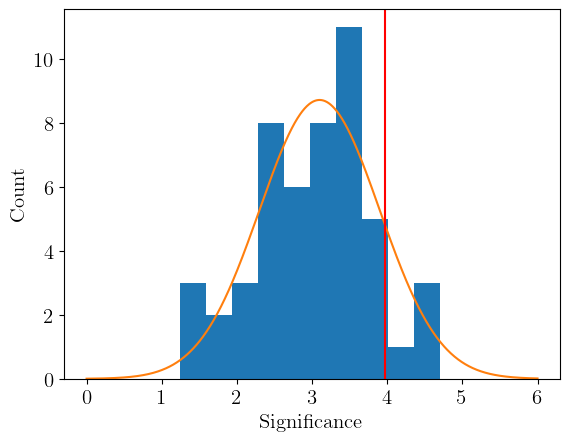

In [497]:
#plotting the significance values of the mock tests, and then in red is from the true data

n, bin_edge, p = plt.hist(sigma_vals, bins = 10)

bins = [(bin_edge[i+1] + bin_edge[i])/2 for i in range(len(bin_edge)-1)]
popt, pcov = curve_fit(gaussian, bins, n)
x = np.linspace(0,6,1000)
y = gaussian(x,popt[0], popt[1], popt[2])

plt.plot(x,y)
plt.axvline(3.97, color = 'r')
plt.xlabel('Significance')
plt.ylabel('Count')

# Comparing how often random sources are within voids versus 4LAC and SDSS in voids

In [611]:
#same function as above, creates population of mock 4lac sources with the same redshift distribution
#  but random locations within the void footprint, and determines the percentage of those sources that are in voids

def resample_invoid(n):
    #p_vals = []
    #ks_vals = []
    #sigma_vals = []

    in_voids = []
    
    k = 0
    while k < n:
        #print(k)
        fourlac_resampled = pd.DataFrame()
        fourlac_resampled['z'] = fourlac.z

        RAdeg = []
        DEdeg = []
        filled = 0
        attempts = 0
        max_attempts = 100000  # safety in case it's small and hard to hit

        while filled < len(fourlac) and attempts < max_attempts:
            # Sample random points in the bounding box
            x_rand = np.random.uniform(minx, maxx)
            y_rand = np.random.uniform(miny, maxy)
            point = Point(x_rand, y_rand)
            if polygon.contains(point):
                RAdeg.append(x_rand)
                DEdeg.append(y_rand)
                filled += 1
            attempts += 1
        
        #print(filled)
        
        fourlac_resampled['RAdeg'] = RAdeg
        fourlac_resampled['DEdeg'] = DEdeg
        cmvd = cosmo.comoving_distance(fourlac_resampled['z']) # Comoving distance to void center
        fourlac_resampled['cmvd_Mpc'] = cmvd.value # add it to data table


        #calculating voidiness of new dataframe
        fourlac_w_voidiness,_ = voidy_analysis(sutter_voids, fourlac_resampled)

        source_coords = get_3d_coordinates(fourlac_w_voidiness['RAdeg'], fourlac_w_voidiness['DEdeg'], fourlac_w_voidiness['z'], fourlac_w_voidiness['cmvd_Mpc'])
        sphere_coords = get_3d_coordinates(sutter_voids['RAdeg'], sutter_voids['DEdeg'], sutter_voids['z'], sutter_voids['cmvd_Mpc'])

        # Checking if point sources are inside any sphere
        source_locs = []
        void_locs = []
        #void_rad = []
        for j in range(len(source_coords)):
            for i in range(len(sphere_coords)):
                distance = np.linalg.norm(source_coords[j] - sphere_coords[i])
        
                if distance <= sutter_voids.iloc[i]['Reff_Mpc']:
                    source_locs.append(j)
                    void_locs.append(i)
                    #void_rad.append(i)

        sources_in_voids = fourlac_w_voidiness.iloc[source_locs]
        voids_w_sources = sutter_voids.iloc[void_locs]

        sources_in_voids_dupdrop = sources_in_voids.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')
        sources_in_voids_dupdrop = sources_in_voids_dupdrop.reset_index(drop=True)

        #print(len(sources_in_voids_dupdrop))
        in_voids.append(len(sources_in_voids_dupdrop))

        k += 1

    return in_voids


In [518]:
output = resample_invoid(500) #just the distant redshift bin

Text(0.5, 0, '\\% of Mock 4LAC Sources in Voids')

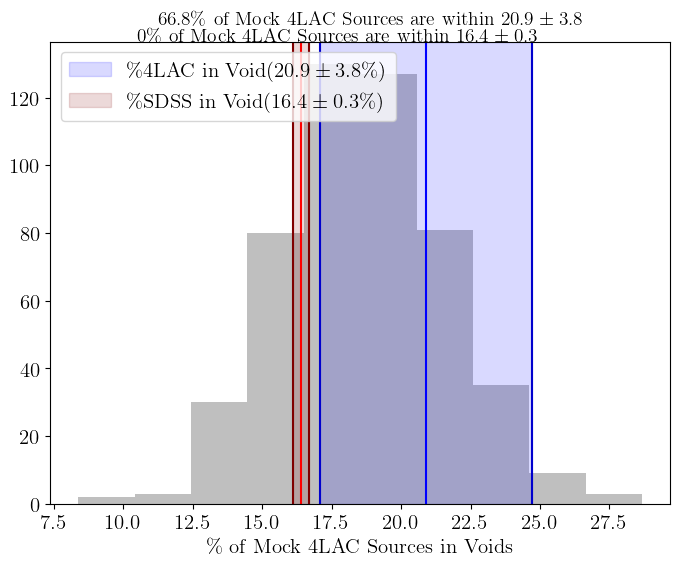

In [628]:
#results for just the distant redshift bin

plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize = (8,6))

#histogram of percentage of mock 4lac sources in voids
plt.hist([(i/143)*100 for i in output], alpha = 0.5, color = 'grey') #% no. sources in voids at high redshift

# actual percentage of 4lac sources in voids
plt.axvline(20.9, c = 'b')
plt.axvline(20.9-3.8, c = 'mediumblue')
plt.axvline(20.9+3.8, c = 'mediumblue')
plt.axvspan(20.9-3.8, 20.9+3.8, alpha = 0.15, color = 'b', label = r'$\% \text{4LAC in Void} (20.9 \pm 3.8 \%)$')

# actual percentage of SDSS sources in voids
plt.axvline(16.4, c = 'r')
plt.axvline(16.4-0.3, c = 'maroon')
plt.axvline(16.4+0.3, c = 'maroon')
plt.axvspan(16.4-0.3, 16.4+0.3, alpha = 0.15, color = 'maroon',label = r'$\% \text{SDSS in Void} (16.4 \pm 0.3 \%)$')

plt.legend(loc = 'upper left')
plt.title(r'$66.8\%$ of Mock 4LAC Sources are within $20.9 \pm 3.8$ \\ $0\%$ of Mock 4LAC Sources are within $16.4 \pm 0.3$', fontsize = 14)
plt.xlabel('\% of Mock 4LAC Sources in Voids')

In [593]:
#determining percent of mock sources that are consistent with 4lac percentage in voids
count = 0
for i in test:
    if (i < 20.9+3.8) & (i > 20.9-3.8):
        count += 1

count/500

In [626]:
#determining percent of mock sources that are consistent with SDSS percentage in voids
count = 0
for i in test:
    if (i < 16.4+.3) & (i > 16.4-.3):
        count += 1

In [629]:
output_full = resample_invoid(500) #full redshift range - had to adjust function

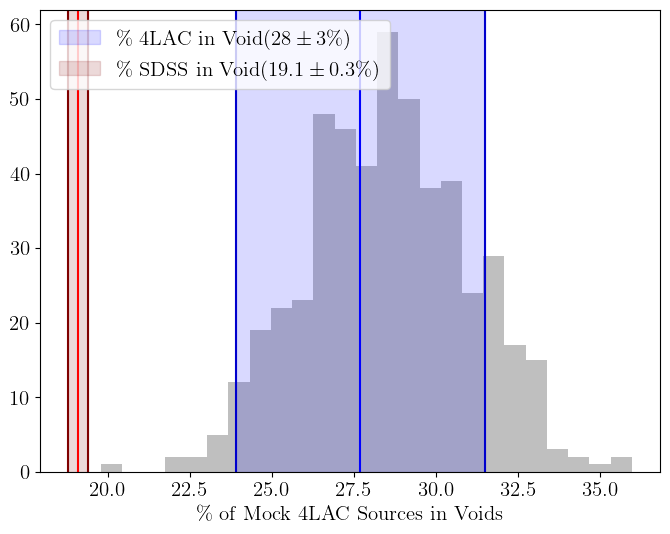

In [648]:
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize = (8,6))
plt.hist([(i/303)*100 for i in output_full], alpha = 0.5, color = 'grey', bins = 25) #% sources in voids at high redshift
plt.axvline(27.7, c = 'b')
plt.axvline(27.7-3.8, c = 'mediumblue')
plt.axvline(27.7+3.8, c = 'mediumblue')
plt.axvspan(27.7-3.8, 27.7+3.8, alpha = 0.15, color = 'b', label = r'$\% ~\text{4LAC in Void} (28 \pm 3 \%)$')

plt.axvline(19.1, c = 'r')
plt.axvline(19.1-0.3, c = 'maroon')
plt.axvline(19.1+0.3, c = 'maroon')
plt.axvspan(19.1-0.3, 19.1+0.3, alpha = 0.15, color = 'maroon',label = r'$\% ~\text{SDSS in Void} (19.1 \pm 0.3 \%)$')

plt.legend(loc = 'upper left')
#plt.title(r'$83.2\%$ of Mock 4LAC Sources are within $28 \pm 3$ \\ $0\%$ of Mock 4LAC Sources are within $19.1\pm 0.3$', fontsize = 14)
plt.xlabel('\% of Mock 4LAC Sources in Voids')

plt.savefig('sources_in_voids.png', dpi = 300, bbox_inches = 'tight')

In [634]:
test = [(i/303)*100 for i in output_full]

In [635]:
count = 0
for i in test:
    if (i < 27.7+3.8) & (i > 27.7-3.8):
        count += 1

In [636]:
count/500

0.832

In [637]:
count = 0
for i in test:
    if (i < 19.1+.3) & (i > 19.1-.3):
        count += 1

In [638]:
count

0

In [ ]:
#calculating percentages of 4lac and sdss sources in voids

In [572]:
sdss = pd.read_excel('exported_dataFrames/sdsssutter_invoids.xlsx')

In [573]:
sdss[sdss.z >= 0.4]

,Unnamed: 0.1,Unnamed: 0,SDSS_NAME,RAdeg,DEdeg,PLATE,MJD,FIBERID,AUTOCLASS_PQN,AUTOCLASS_DR14Q,...,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,SN_MEDIAN_ALL,cmvd_Mpc,Voidiness,Void_Dist_Mpc
0,4,4,b'074318.11+240953.0',115.825470,24.164732,11103,58488,626,QSO,b'QSO',...,0,-110.751442,259.947815,b'eboss27',17635,15.02270,1.646996,1984.177536,0.152967,303.512764
1,15,15,b'074423.46+260803.3',116.097754,26.134267,4462,55600,808,QSO,b'QSO',...,0,54.671295,42.906563,b'boss14',11075,10.45210,4.288174,1767.423239,0.112523,198.875869
2,16,16,b'074433.22+263334.7',116.138427,26.559655,11095,58439,972,QSO,b'QSO',...,0,268.954254,38.991104,b'eboss27',17622,13.02770,2.179825,2268.274806,0.137897,312.788057
3,18,18,b'074455.19+202747.4',116.229989,20.463190,11082,58508,280,QSO,b'QSO',...,0,27.730366,-2.878066,b'eboss27',17599,9.82116,4.685452,2358.143080,0.265001,624.910476
4,20,20,b'074502.44+260535.7',116.260181,26.093261,4462,55600,858,QSO,b'QSO',...,0,86.432755,34.086105,b'boss14',11075,10.45210,7.064243,2274.701867,0.230265,523.784167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,75811,75811,b'171617.69+311931.8',259.073712,31.325516,4998,55722,374,QSO,b'QSO',...,0,-118.361961,-179.523010,b'boss18',13531,10.94550,1.429735,2386.125188,0.303447,724.062180
3763,75844,75844,b'171714.28+345700.7',259.309533,34.950215,10724,58391,200,QSO,b'QSO',...,0,46.050373,-74.235008,b'eboss3',16385,12.81530,3.672686,2076.545491,0.276813,574.814962
3764,75855,75855,b'171746.62+274043.4',259.444271,27.678738,5003,55715,658,QSO,b'QSO',...,0,-120.008018,-10.569472,b'boss18',13536,10.46210,3.838324,2057.745605,0.190726,392.465123
3765,75863,75863,b'171817.25+314603.9',259.571903,31.767769,11654,58543,800,QSO,b'QSO',...,0,58.666901,134.275040,b'eboss3',16386,10.41210,4.894783,2292.717993,0.201877,462.847995


In [574]:
sdss_tot = pd.read_excel('exported_dataFrames/sdsssutter_w_voidiness_dup_drop_above_z0_1.xlsx')

In [575]:
sdss_tot[sdss_tot.z >= 0.4]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SDSS_NAME,RAdeg,DEdeg,PLATE,MJD,FIBERID,AUTOCLASS_PQN,...,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,SN_MEDIAN_ALL,cmvd_Mpc,Voidiness,Void_Dist_Mpc
0,4,4,4,b'074318.11+240953.0',115.825470,24.164732,11103,58488,626,QSO,...,0,-110.751442,259.947815,b'eboss27',17635,15.0227,1.646996,1984.177536,0.152967,303.512764
1,5,5,5,b'074331.20+225539.2',115.880016,22.927580,4470,55587,142,QSO,...,0,84.645218,-132.694763,b'boss14',11074,12.7829,4.834815,2440.963321,0.245845,600.099209
2,13,13,13,b'074417.38+221410.7',116.072456,22.236319,11103,58488,317,QSO,...,0,-62.475685,-160.307037,b'eboss27',17635,15.0227,2.029319,2382.724916,0.287163,684.231258
3,15,15,15,b'074423.46+260803.3',116.097754,26.134267,4462,55600,808,QSO,...,0,54.671295,42.906563,b'boss14',11075,10.4521,4.288174,1767.423239,0.112523,198.875869
4,16,16,16,b'074433.22+263334.7',116.138427,26.559655,11095,58439,972,QSO,...,0,268.954254,38.991104,b'eboss27',17622,13.0277,2.179825,2268.274806,0.137897,312.788057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19743,75901,75901,75901,b'171945.98+261302.7',259.941598,26.217424,5016,55709,712,QSO,...,0,-71.641563,142.209427,b'boss18',13549,11.7267,3.654042,1946.014309,0.109879,213.826047
19746,75910,75910,75910,b'172102.59+314002.3',260.260800,31.667327,11654,58543,962,QSO,...,0,186.453033,113.245499,b'eboss3',16386,10.4121,2.647143,2202.123202,0.134321,295.792032
19748,75914,75914,75914,b'172122.68+313010.2',260.344532,31.502840,4998,55722,144,QSO,...,0,117.811249,-140.879547,b'boss18',13531,10.9455,3.782367,2416.662120,0.122275,295.496749
19749,75917,75917,75917,b'172217.26+301710.0',260.571918,30.286116,11654,58543,47,QSO,...,0,247.979126,-187.193176,b'eboss3',16386,10.4121,3.184899,2474.060624,0.039522,97.779941


In [625]:
(2689/16425)*100

16.371385083713854

In [624]:
(np.sqrt(2689)/16425)*100

0.31571122465666174

In [630]:
30/143

0.2097902097902098

In [641]:
sdss[sdss.z <0.4]

,Unnamed: 0.1,Unnamed: 0,SDSS_NAME,RAdeg,DEdeg,PLATE,MJD,FIBERID,AUTOCLASS_PQN,AUTOCLASS_DR14Q,...,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,SN_MEDIAN_ALL,cmvd_Mpc,Voidiness,Void_Dist_Mpc
32,190,190,b'074900.39+211700.1',117.251657,21.283372,11112,58428,538,QSO,b'QSO',...,0,-265.144928,-12.438608,b'eboss27',17648,15.0636,7.613945,1567.012422,0.271247,425.047587
47,375,375,b'075128.57+202358.0',117.869065,20.399456,11112,58428,370,QSO,b'QSO',...,0,-140.615479,-205.779785,b'eboss27',17648,15.0636,4.502501,1538.645926,0.366693,564.210392
71,619,619,b'075401.44+262908.8',118.506000,26.485797,11114,58437,577,QSO,b'QSO',...,0,-194.924866,47.152599,b'eboss27',17650,12.8961,10.888376,818.815157,0.150491,123.224071
75,663,663,b'075429.62+215534.2',118.623428,21.926167,4471,55617,483,QSO,b'QSO',...,0,-289.369843,-134.897415,b'boss14',11090,12.3384,5.869421,1390.081969,0.509141,707.748130
76,666,666,b'075430.13+215322.4',118.625550,21.889558,4471,55617,459,QSO,b'QSO',...,0,-289.044098,-142.900284,b'boss14',11090,12.3384,3.847183,1562.164718,0.483968,756.038277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,75715,75715,b'171145.75+350927.7',257.940645,35.157709,4994,55739,525,QSO,b'QSO',...,175,-226.318039,121.088722,b'boss18',13527,12.4858,7.666214,1269.096828,0.301141,382.176479
3754,75758,75758,b'171349.54+343417.8',258.456431,34.571624,10724,58391,375,QSO,b'QSO',...,0,-106.645401,-156.490280,b'eboss3',16385,12.8153,4.739484,1271.701406,0.294695,374.764236
3756,75778,75778,b'171432.91+345644.7',258.637131,34.945764,10724,58391,307,QSO,b'QSO',...,0,-73.850502,-75.121941,b'eboss3',16385,12.8153,4.147591,941.740805,0.216084,203.494770
3760,75786,75786,b'171457.94+292144.3',258.741456,29.362318,5001,55719,428,QSO,b'QSO',...,0,-180.556366,-84.746887,b'boss18',13534,10.5232,1.615168,1085.677895,0.178895,194.221978


In [642]:
1079/16425

0.06569254185692541

In [643]:
fourlac_invoids = pd.read_excel('exported_dataFrames/4lacsutter_invoids.xlsx')

In [644]:
fourlac_invoids

,Unnamed: 0.10,Unnamed: 0.6,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,...,FluxInc80,FluxInc90,FluxInc95,FluxInc30,FluxInc40,FluxInc45,Voidiness_Cut,Voidiness_Cut2,Voidi-Oidyness,Voidi-Oidyness2
0,0,5,0,0,0,5,5,5,8,1172,...,2.408246e-13,2.141012e-13,2.028467e-13,6.406332e-13,4.809439e-13,4.276449e-13,0.402837,0.446752,0.048792,0.004877
1,1,9,1,1,1,9,9,9,13,1191,...,5.220057e-13,4.641160e-13,4.397331e-13,1.387043e-12,1.041771e-12,9.264602e-13,0.578045,0.526870,0.046862,0.098037
2,2,22,2,2,2,22,22,22,27,1237,...,5.258297e-13,4.675573e-13,4.430101e-13,1.395358e-12,1.048569e-12,9.326703e-13,0.241376,0.243124,0.062023,0.060275
3,3,23,3,3,3,23,23,23,28,1238,...,1.473508e-12,1.311471e-12,1.243120e-12,3.855000e-12,2.913301e-12,2.596201e-12,0.092971,0.106164,0.059335,0.046142
4,4,36,4,4,4,36,36,36,41,1286,...,1.778660e-12,1.583375e-12,1.500977e-12,4.640061e-12,3.510549e-12,3.129632e-12,0.001176,0.051079,0.080144,0.030240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,292,79,79,79,292,292,292,316,2507,...,2.450596e-13,2.178652e-13,2.064123e-13,6.519467e-13,4.894230e-13,4.351801e-13,0.495308,0.513108,0.056454,0.038654
80,80,293,80,80,80,293,293,293,317,2513,...,6.875558e-13,6.116577e-13,5.796637e-13,1.811402e-12,1.365127e-12,1.215407e-12,0.069141,0.100881,0.054528,0.022788
81,81,297,81,81,81,297,297,297,321,2531,...,6.098033e-14,5.421383e-14,5.136409e-14,1.622062e-13,1.217769e-13,1.082824e-13,0.334024,0.326087,0.027223,0.035160
82,82,299,82,82,82,299,299,299,323,2542,...,2.500040e-12,2.225528e-12,2.109703e-12,6.522978e-12,4.934809e-12,4.399258e-12,0.094744,0.133916,0.073518,0.034346


In [645]:
54/303

0.1782178217821782